In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from neuron import h
import pds_plots as ppl
import matplotlib.pyplot as plt
from pop_generation.mf_generation import Bridson_sampling_2d

h.load_file('test/set3005/Parameters.hoc')
h.MFxrange += 50
h.MFyrange += 50
h.GLdepth += 50

/opt/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Nseg for APical is 5 and Basal is 3
	36 


1.0

In [62]:
# h.MFxrange = 700 + 50
# h.MFyrange = 700 + 50
# h.GLdepth = 200 + 50

def compute_mf_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    n_mf = int((Transverse_range + (2 * Xinstantiate)) * (Horizontal_range + (2 * Yinstantiate)) * MFdensity * 1e-6)
    print('N MF = {}'.format(n_mf))
    return ((Horizontal_range, Transverse_range), n_mf)

mf_box, n_mf = compute_mf_params(h)

spacing_mf = 14.5
mf_points = Bridson_sampling_2d(mf_box, spacing_mf, n_mf, True)
mf_box

N MF = 3031


Iteration: 29, (final)Points Created: 3031, is_grid_empty:8214 (100.0%)


(1550.0, 750.0)

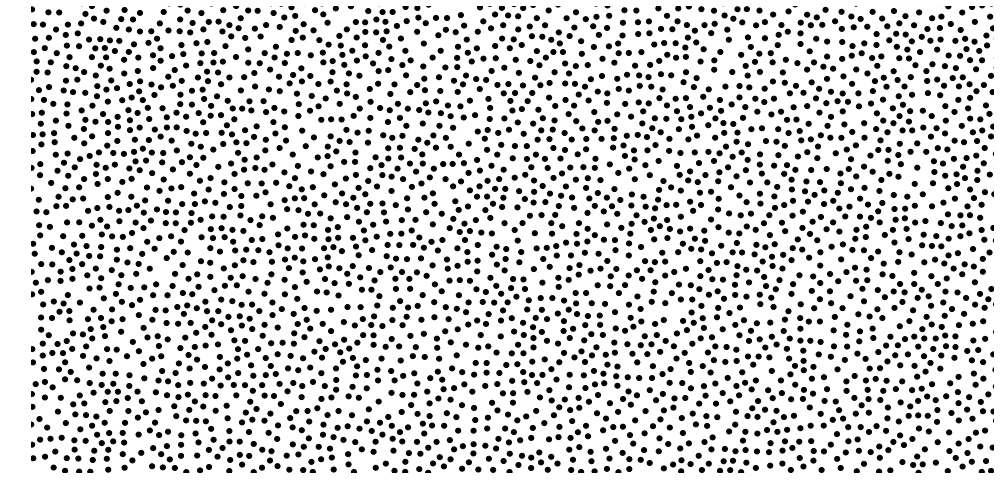

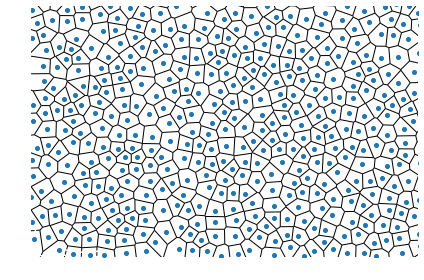

In [64]:
ppl.plot_mf_1(mf_points, [1500, 750], 4, save=True)
ppl.plot_mf_2(mf_points, [1500, 750], save=True)

In [85]:
def compute_goc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth + 50
    
    Volume = Transverse_range * Horizontal_range * Vertical_range

    d_goc = h.GoCdensity
    n_goc = int(d_goc * Volume * 1e-9)
    return ((Horizontal_range, Transverse_range, Vertical_range), n_goc)


goc_box, n_goc = compute_goc_params(h)

In [86]:
# spacing_glo = 6.6-1 #(Billings et al., 2014) Since glomeruli is elipsoid shape, I recalculated based on the spatial occupancy of glomeruli and its density. Also, I subtract 1 cuz I will give Gaussian noise
# spacing_grc = 6-1 # (Billings et al., 2014) I subtract 1 because I will give Gaussian noise

# #Density of cells (mm^-3)
# d_goc = 9500  # (Dugue GP et al., 2009)
# d_glo = 6.6 * 1e5 #(Billings et al., 2014)
# d_grc = 1.9 * 1e6 #(Billings et al., 2014)

spacing_goc = 45.5-1 #40 #(NH Barmack, V Yakhnitsa, 2008)

from pop_generation.mf_generation import Bridson_sampling_3d

goc_points = Bridson_sampling_3d(goc_box, spacing_goc, n_goc, True)
goc_points = goc_points + np.random.normal(0, 1, size=(len(goc_points), 3)) #Gaussian noise

Iteration: 8850, (final)Points Created: 3313, is_grid_empty:18647 (84.91347905282332%)


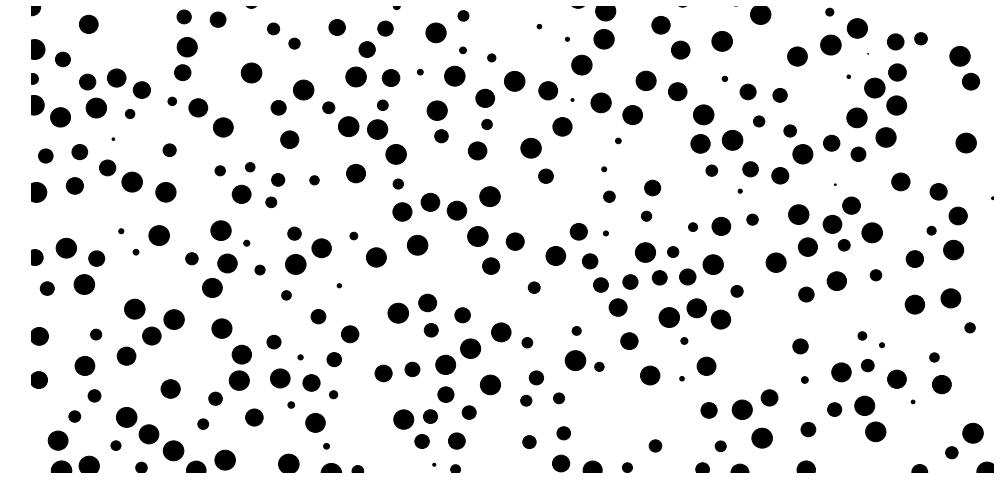

In [87]:
ppl.plot_goc(goc_points, [1500, 750], 100, 16, save=True)

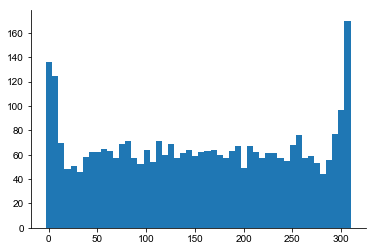

In [88]:
_ = plt.hist(goc_points[:, 2], 50)

In [89]:
from sklearn.neighbors import KDTree
goc_tree = KDTree(goc_points)
d_goc_glo = 38/2+(6.6)/1.5-1
def fgoc(x):
    y = x.copy()
    y[:, 1] = y[:, 1]*3
    nnsearch = goc_tree.query_radius(y, r=d_goc_glo, count_only=True)
    return (nnsearch==0)
#     return np.array([nn.size==0 for nn in nnsearch])
# glos = glo_points[fgoc(glo_points),:]

In [90]:
def compute_glo_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_glo = 6.6 * 1e5 #(Billings et al., 2014)
    n_glo = int(d_glo * Volume * 1e-9)
    print("N of Glomeruli = {}".format(n_glo))

    return ((Horizontal_range, Transverse_range//3, Vertical_range), n_glo)

#Glomerulus (Rosettes)
from pop_generation.second_generation import Bridson_sampling_2



globox, n_glo = compute_glo_params(h)
spacing_glo = 6.6-0.5 #(Billings et al., 2014) Since glomeruli is elipsoid shape, I recalculated based on the spatial occupancy of glomeruli and its density. Also, I subtract 1 cuz I will give Gaussian noise

glo_points = Bridson_sampling_2(globox, spacing_glo, n_glo, True, ftests=[fgoc])
glo_points[:, 1] = glo_points[:, 1]*3 # Since glomerulus is stretched for Horizontal section, we will generate coordinates in small area at first, and then multiply it with 3. (Billings et al., 2014)

y = glo_points.copy()
y[:,1] = y[:,1]/3
assert(fgoc(y).prod()==1)

glo_points = glo_points+np.random.normal(0, 0.5, size=(len(glo_points), 3))


N of Glomeruli = 191812


Iteration: 229, (final)Points Created: 191812, is_grid_empty:2031238 (91.37039990895518%)


In [91]:
# glopt1 = glo_points.copy()

In [92]:
print(glo_points[:,0].max(),
glo_points[:,1].max(),
glo_points[:,2].max())

1554.5831453191195 751.3746443576648 251.5159392266406


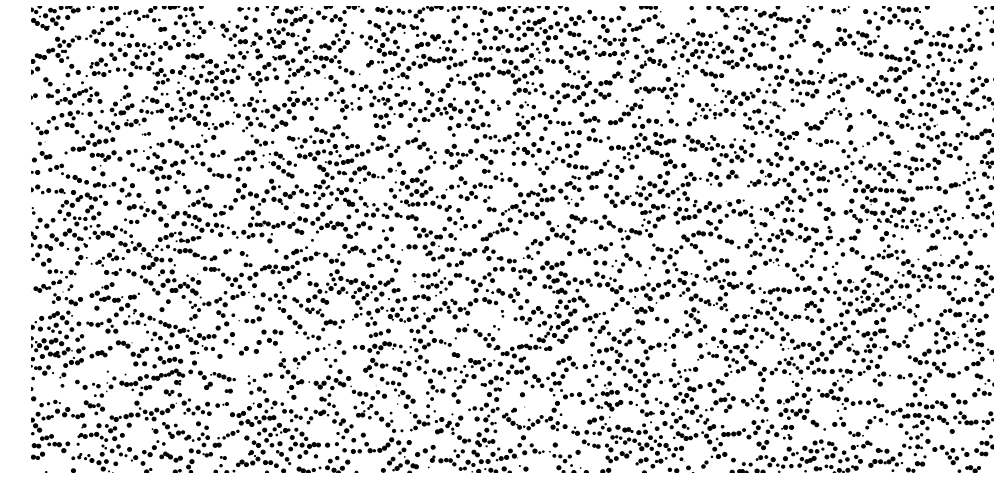

In [93]:
ppl.plot_glo(glo_points, [1500, 750], 50, 3.3)

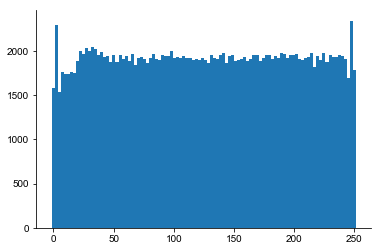

In [94]:
_ = plt.hist(glo_points[:, 2], 100)

(25, 225)

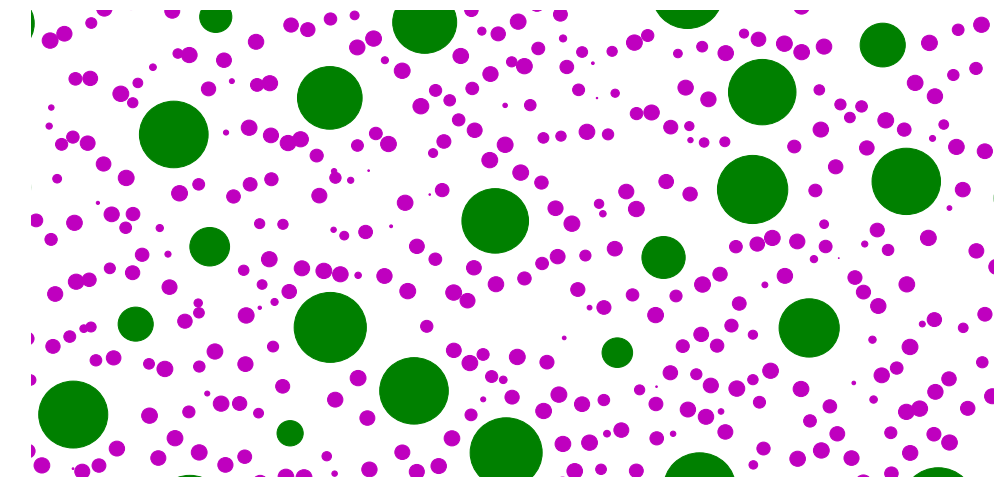

In [95]:
ppl.plot_goc_glo((goc_points, 15), (glo_points, 6.6/2), [1500, 750], 100, save=True)
plt.xlim([25, 425])
plt.ylim([25, 225])

In [96]:
d_goc_grc = 38/2+6/2-1
def fgoc(x):
    nnsearch = goc_tree.query_radius(x, r=d_goc_grc, count_only=True).astype(bool)
    return (nnsearch==0)


glo_tree = KDTree(glo_points)
d_glo_grc = 6.6/1.5 + 6/2-1
def fglo(x):
    nnsearch = glo_tree.query_radius(x, r=d_glo_grc, count_only=True).astype(bool)
    return (nnsearch==0)


In [97]:
# from pop_generation.third_generation import Bridson_sampling_third

def compute_grc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_grc = 1.9 * 1e6 #(Billings et al., 2014)
    n_grc = int(d_grc * Volume * 1e-9)

    print("N of GrC = {}".format(n_grc))

    return ((Horizontal_range, Transverse_range, Vertical_range), n_grc)


spacing_grc = 6-1 # (Billings et al., 2014) I subtract 1 because I will give Gaussian noise

grcbox, n_grc = compute_grc_params(h)

grc_points = Bridson_sampling_2(grcbox, spacing_grc, n_grc, True, ftests=[fgoc, fglo])
# grc_points = Bridson_sampling_2(grcbox, spacing_grc, n_grc, True)



N of GrC = 552187


Iteration: 343, (final)Points Created: 552187, is_grid_empty:11594557 (95.45249256191272%)


In [98]:
# grcs = grc_points[fglo(grc_points)]
# grcs = grc_points[fglo(grc_points)*fgoc(grc_points)]

(25, 225)

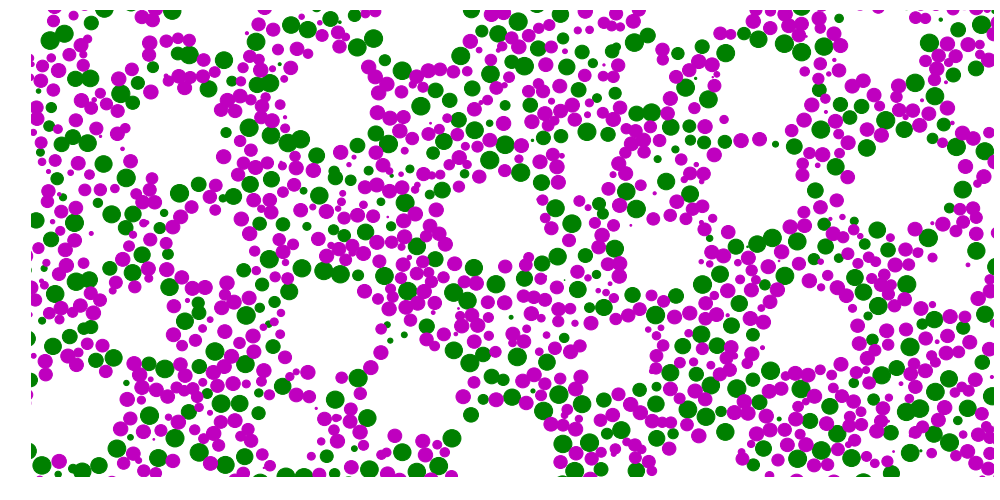

In [99]:
ppl.plot_goc_glo((glo_points, 6.6/1.75),(grc_points, 3), [1500, 750], 100)
plt.xlim([25, 425])
plt.ylim([25, 225])

(25, 225)

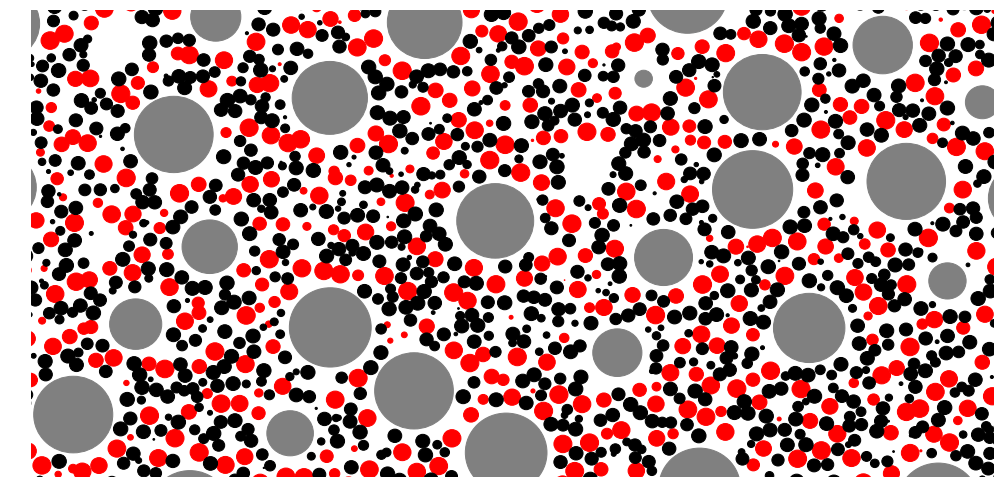

In [104]:
ppl.plot_all_pop((goc_points, 17), (glo_points, 6.6/1.75), (grc_points, 3), [1500, 750], 100, save=True)
plt.xlim([25, 425])
plt.ylim([25, 225])

In [102]:
np.savez("coords_20190604_1.npz", mf=mf_points, goc=goc_points, glo=glo_points, grc_nop=grc_points)